In [1]:
from keras import backend as K
import numpy as np
import PIL.Image as Image
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
def s(a): plt.imshow(a)


# disable eager execution
# tf.compat.v1.disable_eager_execution()

Text(0.5, 1.0, 'Task 1: Input image')

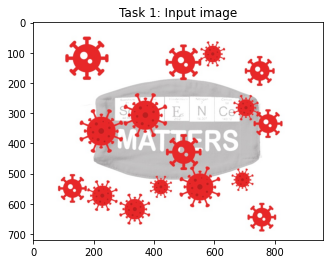

In [2]:
img_raw = Image.open('Input.png')
img_raw = np.array(img_raw)
# display it
plt.imshow(img_raw)
plt.title('Task 1: Input image')

Text(0.5, 1.0, 'Task 2: Binary image')

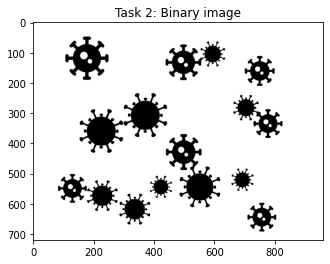

In [3]:
# hte magic number is by convention
img_gray = np.dot(img_raw[..., :3], [0.299, 0.587, 0.114])
# an alternative way is use cv2 to auto-find the best cut
threshold = 155
img_bin = img_gray > threshold
img_bin = img_bin.astype(np.uint8) * 255
img_bin_rgb = cv2.cvtColor(img_bin, cv2.COLOR_GRAY2RGB)
plt.imshow(img_bin_rgb)
plt.title('Task 2: Binary image')

there are 16 virus


Text(0.5, 1.0, 'Task 3: Instance counting')

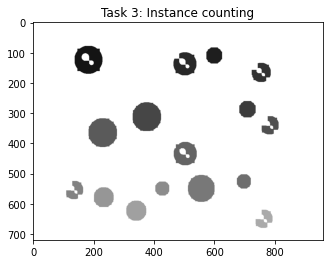

In [4]:
# count the number of instance

def bfs(grid, i, j, color):
    """
    BFS on a 2D grid, where the instance is marked as 255.
    mark as visited by setting the pixel another color.
    Parameters
    ----------
    grid : ndarray
        2D grid, where the instance is marked as 255.
    i : int
        row index
    j : int
        column index
    color : int
        color to mark the instance
    """
    queue = [[i, j]]
    while queue:
        [i, j] = queue.pop(0)
        if 0 <= i < grid.shape[0]-1 and 0 <= j < grid.shape[1]-1 and grid[i, j] == 0:
            # mark as visited by setting it to another color
            grid[i][j] = color
            queue += [[i + 1, j], [i - 1, j], [i, j - 1], [i, j + 1]]


def count(img) -> int:
    """
    Use depth-first search to count the number of instance on a 2D grid,
    where the instance is marked as 0.

    Input: img [H, W], uint8, 0 means instance
    Output: int, the number of instance
    """
    # assume there are at most 23 instance
    color = [_*10 for _ in range(2, 25)]
    cnt = 0
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i, j] != 0:
                continue
            bfs(img, i, j, color[cnt])
            cnt += 1
    return cnt


# use erosion and dilation to remove occlusion of instance
kernel = np.ones((4, 4), np.uint8)
img_bin_erosion = cv2.erode(1-img_bin/255, kernel, iterations=5)
img_bin_dialate = cv2.dilate(img_bin_erosion, kernel, iterations=5)
# covert to uint8, where 255 means background
img_bin_dialate = ((1-img_bin_dialate)*255).astype(np.uint8)
# plt.imshow(img_bin_erosion)
# plt.title('Task 3: Erosion and dilation')
print("there are %d virus" % count(img_bin_dialate))
plt.imshow(cv2.cvtColor(img_bin_dialate, cv2.COLOR_GRAY2RGB))
plt.title('Task 3: Instance counting')

Text(0.5, 1.0, 'Visualization of bounding box')

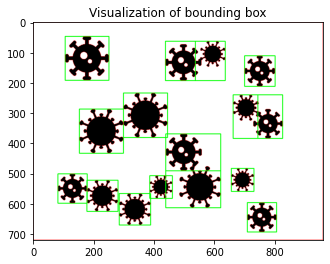

In [5]:
# find contour
ret, thresh = cv2.threshold(cv2.cvtColor(
    img_bin_rgb.copy(), cv2.COLOR_BGR2GRAY), 127, 255, cv2.THRESH_BINARY)
contours, hier = cv2.findContours(
    thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

img_contour = img_bin_rgb.copy()
# find axis-aligned bounding box of each instance
aabb = list()
for c in contours:
    # find bounding box coordinates
    x, y, w, h = cv2.boundingRect(c)
    # skip small boxes
    if x == 0 and y == 0 or w < 40 or h < 40:
        continue

    # if the box is likely to contain 2 instances
    if w > h * 1.1:
        # divide it into 2 boxes
        aabb.append([x, y, w//2, h])
        cv2.rectangle(img_contour, (x, y), (x+w//2, y+h), (0, 255, 0), 2)
        x += w//2
        aabb.append([x, y, w//2, h])
        cv2.rectangle(img_contour, (x, y), (x+w//2, y+h), (0, 255, 0), 2)
        continue
    if h > w * 1.1:
        aabb.append([x, y, w, h//2])
        cv2.rectangle(img_contour, (x, y), (x+w, y+h//2), (0, 255, 0), 2)
        y += h//2
        aabb.append([x, y, w, h//2])
        cv2.rectangle(img_contour, (x, y), (x+w, y+h//2), (0, 255, 0), 2)
        continue
    aabb.append([x, y, w, h])
    cv2.rectangle(img_contour, (x, y), (x+w, y+h), (0, 255, 0), 2)

# visualize the contour
cv2.drawContours(img_contour, contours, -1, (255, 0, 0), 1)
plt.imshow(img_contour)
plt.title("Visualization of bounding box")

In [6]:
# we first need to synthesize the training data
# get the instace
virus_2 = img_bin[50:190, 105:250]
# resize to 80*80, which is the size of the input of the classifier
virus_2 = cv2.resize(virus_2, (80, 80))
virus_2_rgb = cv2.cvtColor(virus_2, cv2.COLOR_GRAY2RGB)

virus_1 = img_bin[565:670, 285:390]
virus_1 = cv2.resize(virus_1, (80, 80))
virus_1_rgb = cv2.cvtColor(virus_1, cv2.COLOR_GRAY2RGB)


# synthesize dataset


def rnd_process(img=None, noise=None):
    """
    randomly resize, translate an image while keeping the same size
    """
    # the upper limit is 80 because of the definition of bounding box
    x_scale = np.random.randint(40, 80)
    y_scale = np.random.randint(40, 80)
    img_rescale = cv2.resize(img, (x_scale, y_scale))
    # randomly translate
    x_off = np.random.randint(0, 80-x_scale)
    y_off = np.random.randint(0, 80-y_scale)
    img_translate = np.ones_like(img)*255  # pure white background
    img_translate[y_off:y_off+y_scale, x_off:x_off+x_scale] = img_rescale

    if noise is not None:
        # randomly crop a region from noise image
        x_noise, y_noise = np.random.randint(00, 40, 2)
        img_translate[y_noise:y_noise+20, x_noise:x_noise +
                      20] = noise[y_noise:y_noise+20, x_noise:x_noise+20]

    # randomly flip
    flip_axis = np.random.randint(0, 2)
    if np.random.randint(0, 2) != 0:
        img_translate = cv2.flip(img_translate, flip_axis)
    return img_translate


# s(rnd_process(virus_2_rgb, virus_1_rgb))


def syn_data(batch_size=64):
    """
    Generate data in batch
    """
    while 1:
        img_batch = np.zeros((batch_size, 80, 80, 3), dtype=np.uint8)
        gt_batch = np.zeros((batch_size, 1), dtype=np.uint8)
        for i in range(batch_size):
            gt = np.random.randint(0, 2)
            if gt == 0:
                img = rnd_process(virus_2_rgb, virus_1_rgb)
            else:
                img = rnd_process(virus_1_rgb, virus_2_rgb)
            img_batch[i] = img
            gt_batch[i] = gt
        yield (img_batch, gt_batch)


# Define a simple CNN model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(80, 80, 3)))
model.add(tf.keras.layers.Conv2D(
    16, (3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(
    32, (3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(
    32, (3, 3), activation='relu', padding='same'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.33))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])
model.fit_generator(syn_data(), epochs=8, steps_per_epoch=10)
# # %% validate
# val_img = rnd_process(virus_1_rgb)
# print(model.predict(val_img[np.newaxis, ...]))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 80, 80, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 40, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 3200)              0

C:\Users\11385\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


10/10 [==============================] - 3s 168ms/step - loss: 91.4025 - accuracy: 0.5136
Epoch 2/8
10/10 [==============================] - 2s 154ms/step - loss: 1.4030 - accuracy: 0.5250
Epoch 3/8
10/10 [==============================] - 1s 144ms/step - loss: 0.6543 - accuracy: 0.6089
Epoch 4/8
10/10 [==============================] - 1s 131ms/step - loss: 0.6216 - accuracy: 0.6586
Epoch 5/8
10/10 [==============================] - 1s 134ms/step - loss: 0.5039 - accuracy: 0.7667
Epoch 6/8
10/10 [==============================] - 1s 128ms/step - loss: 0.4012 - accuracy: 0.8324
Epoch 7/8
10/10 [==============================] - 1s 137ms/step - loss: 0.3008 - accuracy: 0.8733
Epoch 8/8
10/10 [==============================] - 2s 167ms/step - loss: 0.1830 - accuracy: 0.9432


In [7]:
pred = []
print("==============Task 4=============")
for i in range(len(aabb)):
    x, y, w, h = aabb[i]
    img_crop = img_bin_rgb[y:y+h, x:x+w]
    img_crop = cv2.resize(img_crop, (80, 80))
    img_crop = img_crop[np.newaxis, ...]
    pred.append(model.predict(img_crop))
    print("The virus near {}, {} is {}".format(
        x, y, "type 1" if pred[i] > 0.5 else "type 2"))
virus_2_cnt = len([x for x in pred if x[0][0] < 0.5])
virus_1_cnt = len([x for x in pred if x[0][0] > 0.5])
print("==================================")
print("There are {} virus 1 and {} virus 2".format(virus_1_cnt, virus_2_cnt))

==============Task 4=============
The virus near 709, 596 is type 2
The virus near 285, 566 is type 1
The virus near 178, 522 is type 1
The virus near 386, 507 is type 1
The virus near 82, 501 is type 2
The virus near 656, 483 is type 1
The virus near 439, 369 is type 2
The virus near 439, 491 is type 1
The virus near 153, 287 is type 1
The virus near 662, 240 is type 1
The virus near 744, 240 is type 2
The virus near 299, 234 is type 1
The virus near 700, 111 is type 2
The virus near 438, 63 is type 2
The virus near 537, 63 is type 1
The virus near 106, 47 is type 2
There are 9 virus 1 and 7 virus 2


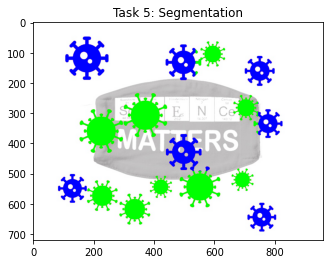

In [8]:
def query_virus_color(y, x, aabb, pred) -> int:
    """
    Given an coordinate, return the color of the virus.

    Return [0,0,0] if it is background.
    Return [0,1,0] if it is virus 1.
    Return [0,0,1] if it is virus 2.
    """
    for i in range(len(aabb)):
        x_, y_, w_, h_ = aabb[i]
        # if in the rectangle
        if x >= x_ and x <= x_+w_ and y >= y_ and y <= y_+h_:
            if pred[i][0][0] > 0.5:
                return np.array([0, 1, 0], dtype=np.uint8)
            else:
                return np.array([0, 0, 1], dtype=np.uint8)

    return np.array([1, 1, 1], dtype=np.uint8)

# Use BFS again to find and color the virus


def bfs(grid, i, j):
    """
    BFS on a 2D grid,
    mark as visited by setting the pixel another color.
    Parameters
    ----------
    grid : ndarray
        2D grid, 
    i : int
        row index
    j : int
        column index
    """
    global aabb, pred
    queue = [[i, j]]
    while queue:
        [i, j] = queue.pop(0)
        if 0 <= i < grid.shape[0]-1 and 0 <= j < grid.shape[1]-1:
            # if this pixel is black
            if not np.any(grid[i, j]):
                # mark as visited by setting it to another color
                grid[i][j] = query_virus_color(i, j, aabb, pred)
                queue += [[i + 1, j], [i - 1, j], [i, j - 1], [i, j + 1]]


def segmentation(img) -> int:
    """
    Use depth-first search to color the virus.

    Input: img [H, W, 3]
    """
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if np.any(img[i, j]):
                continue
            bfs(img, i, j)


img_seg = img_bin_rgb.copy()
segmentation(img_seg)
img_seg = img_seg*255
instance_mask = (255 - img_bin)/255
instance_mask = np.broadcast_to(instance_mask[..., np.newaxis], img_raw.shape)
bcg_mask = 1 - instance_mask
# get the background segmentation
img_background = (img_raw * bcg_mask).astype(np.uint8)
img_seg = img_seg * instance_mask
img_seg = img_seg.astype(np.uint8)

# add background to the segmentation
img_seg = img_seg + img_background
plt.imshow(img_seg)
plt.title("Task 5: Segmentation")
# export segmentation result
Image.fromarray(img_seg).save("output.png")